In [1]:
### this notebook is about stacked LSTM with 4 stacked layers of 50 neurons each on predicting Google Stock Price 
### using non-overlapping X-training, epochs = 100
import pandas as pd ### this automatically will call up 'from pandas import read_csv' when pd.read.csv... is used
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
### imports apps (specialized functions)

In [2]:
P = pd.read_csv("GOOG.csv")  
print(P)

            Date       Open       High        Low      Close  Adj Close  \
0       3/1/2012  16.262545  16.641375  16.248346  16.573130  16.573130   
1       4/1/2012  16.563665  16.693678  16.453827  16.644611  16.644611   
2       5/1/2012  16.491436  16.537264  16.344486  16.413727  16.413727   
3       6/1/2012  16.417213  16.438385  16.184088  16.189817  16.189817   
4       9/1/2012  16.102144  16.114599  15.472754  15.503389  15.503389   
...          ...        ...        ...        ...        ...        ...   
1252  22/12/2016  39.618000  39.666000  39.429001  39.563000  39.563000   
1253  23/12/2016  39.544998  39.637001  39.363998  39.495499  39.495499   
1254  27/12/2016  39.534000  39.893002  39.382851  39.577499  39.577499   
1255  28/12/2016  39.685001  39.711498  39.160000  39.252499  39.252499   
1256  29/12/2016  39.166500  39.296501  38.945999  39.139500  39.139500   

         Volume  
0     147611217  
1     114989399  
2     131808205  
3     108119746  
4     233

In [3]:
Price=P["Adj Close"] 
print(Price)

0       16.573130
1       16.644611
2       16.413727
3       16.189817
4       15.503389
          ...    
1252    39.563000
1253    39.495499
1254    39.577499
1255    39.252499
1256    39.139500
Name: Adj Close, Length: 1257, dtype: float64


Text(0.5, 1.0, 'Historical Google Stock Price 3 Jan 2012 to 29 Dec 2016')

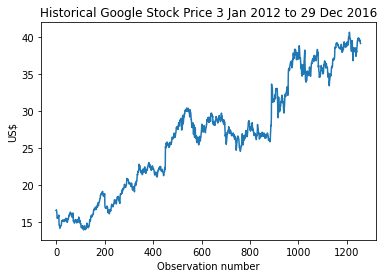

In [4]:
### view time series graph of data -- is it stationary?
Price.plot()
plt.xlabel('Observation number')
plt.ylabel('US$')
plt.title('Historical Google Stock Price 3 Jan 2012 to 29 Dec 2016')

In [5]:
### we cannot use 'train_data = VIX.sample(frac=0.8, random_state=1); test_data = VIX.drop(train_data.index)'
### as this is time series data that is sequenced and cannot be randomly chopped up
train_data = Price[range(1100)]
test_data = Price[1100:]

In [6]:
train_data.shape, test_data.shape  ### train data approx 87.5%

((1100,), (157,))

In [7]:
type(train_data), type(test_data)

(pandas.core.series.Series, pandas.core.series.Series)

In [8]:
train_data.values.reshape(-1, 1)

array([[16.57313 ],
       [16.644611],
       [16.413727],
       ...,
       [35.5415  ],
       [35.824501],
       [35.311501]])

In [9]:
#Performing Feature Scaling
#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))  ### putting all positive is suitable as vola are all pos nos.
train_data = scaler.fit_transform(train_data.values.reshape(-1, 1)) ### (-1,1) reshapes it to a 2D array; 
### without .values - it may not work; .values .values convert to np array, the axes labels will be removed.
test_data = scaler.fit_transform(test_data.values.reshape(-1, 1)) ### (-1,1) reshapes it to a 2D array

In [10]:
type(train_data), type(test_data)

(numpy.ndarray, numpy.ndarray)

In [11]:
train_data.shape, test_data.shape

((1100, 1), (157, 1))

Text(0.5, 1.0, 'Historical Daily Scaled Price 3 Jan 2012 to 29 Dec 2016')

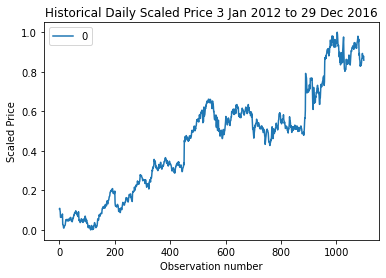

In [12]:
### view scaled time series graph of data -- need to convert np array back to pandas df to use plot feature
trdata=pd.DataFrame(train_data)
trdata.plot()
plt.xlabel('Observation number')
plt.ylabel('Scaled Price')
plt.title('Historical Daily Scaled Price 3 Jan 2012 to 29 Dec 2016')

In [13]:
### Preparing the input X and target Y
def get_XY(dat, time_steps):
    ### Indices of target array
    C_ind = np.arange(time_steps, len(dat), time_steps) 
        ### example np.arange(start=1, stop=10, step=3) gives array([1, 4, 7]), ends up to/before stop
    C = dat[C_ind]
        ### example: ray=np.arange(2, stop=10, step=3); print(ray) --- gives [2 5 8]
        ### c=np.array([1,3,6,8,9,10,12,15,18,20]); c[ray] --- gives array([ 6, 10, 18]) 
        ### with elements from the 2nd, 5th, 8th positions of c. c's 1st position starts at '0'

    ### Prepare X
    rows_x = len(C)                              
    X = dat[range(time_steps*rows_x)]           
    X = np.reshape(X, (rows_x, time_steps, 1))   
    return X, C
 
time_steps = 10  

trainX, trainY = get_XY(train_data, time_steps)
testX, testY = get_XY(test_data, time_steps)

In [14]:
len(train_data), type(train_data)

(1100, numpy.ndarray)

In [15]:
trainX.shape, trainY.shape 


((109, 10, 1), (109, 1))

In [16]:
testX.shape, testY.shape 


((15, 10, 1), (15, 1))

In [17]:
from keras.layers import LSTM
from keras.layers import Dropout

In [18]:
model=Sequential()

In [19]:
model.add(LSTM(units=50,return_sequences=True,input_shape=(trainX.shape[1],1)))
model.add(Dropout(0.0))

In [20]:
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.0))

In [21]:
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.0))

In [22]:
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.0))

In [23]:
model.add(Dense(units=1))

In [24]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [25]:
model.fit(trainX, trainY, epochs=100, batch_size=10)

Epoch 1/100
11/11 [==============================] - 3s 9ms/step - loss: 0.1868
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1092
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0927
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0786
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0645
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0490
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0409
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0368
Epoch 9/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0334
Epoch 10/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0304
Epoch 11/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0276
Epoch 12/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0250
Epoch 13/100
11/11 [=================

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 10, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 10, 50)            2

In [27]:
predict_train=model.predict(trainX)
print(predict_train.shape)

4/4 [==============================] - 1s 3ms/step
(109, 10, 1)


In [28]:
print(predict_train)

[[[0.1381352 ]
  [0.10314917]
  [0.09602955]
  ...
  [0.06439997]
  [0.05872035]
  [0.05629782]]

 [[0.11325356]
  [0.07196505]
  [0.03302571]
  ...
  [0.01054795]
  [0.00866554]
  [0.0062727 ]]

 [[0.07484229]
  [0.01637554]
  [0.0208574 ]
  ...
  [0.04091898]
  [0.03934988]
  [0.03643819]]

 ...

 [[0.95214796]
  [0.90503883]
  [0.91527116]
  ...
  [0.9399648 ]
  [0.9291215 ]
  [0.91629326]]

 [[0.963065  ]
  [0.90749764]
  [0.92351294]
  ...
  [0.95553577]
  [0.9672762 ]
  [0.94322765]]

 [[0.97848046]
  [0.9437001 ]
  [0.8812746 ]
  ...
  [0.8369069 ]
  [0.84319973]
  [0.8311813 ]]]


In [29]:
predict_train=predict_train[:,0]

In [30]:
predicted_stock_price=model.predict(testX)

1/1 [==============================] - 0s 14ms/step


In [31]:
predicted_stock_price=predicted_stock_price[:,0]

In [32]:
from sklearn.metrics import mean_squared_error
import math
train_rmse=math.sqrt(mean_squared_error(trainY,predict_train))
test_rmse=math.sqrt(mean_squared_error(testY,predicted_stock_price))
print('Train RMSE',train_rmse)
print('Test RMSE',test_rmse)

Train RMSE 0.05492522096204993
Test RMSE 0.16445165832538428


In [33]:
### See also https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvline.html
def plot_result(trainY, testY, predict_train, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(predict_train, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='b', linestyle='--')  ### note the vertical red line is drawn to separate the training part from test part
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Price in $')
    plt.title('Google Stock Price Prediction using non-overlapping data with 10-day intervals. The Red Line Separates The Training And Test Examples')

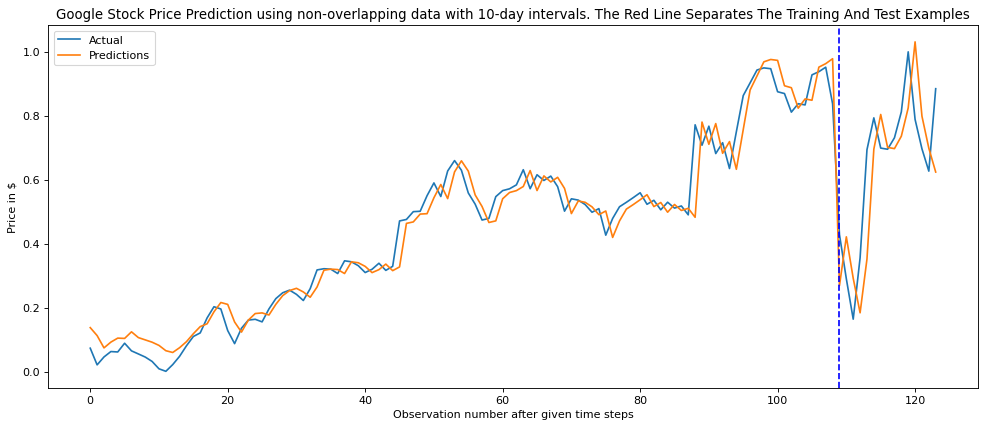

In [34]:
### Plot result -- this puts together Actual = (trainY,testY) or 187+46 points, and Predicted = (train_predict, test_predict)
plot_result(trainY, testY, predict_train, predicted_stock_price)

In [35]:
trainY1 = scaler.inverse_transform(trainY)
testY1 = scaler.inverse_transform(testY)
train_predict1 = scaler.inverse_transform(predict_train)
test_predict1 = scaler.inverse_transform(predicted_stock_price)

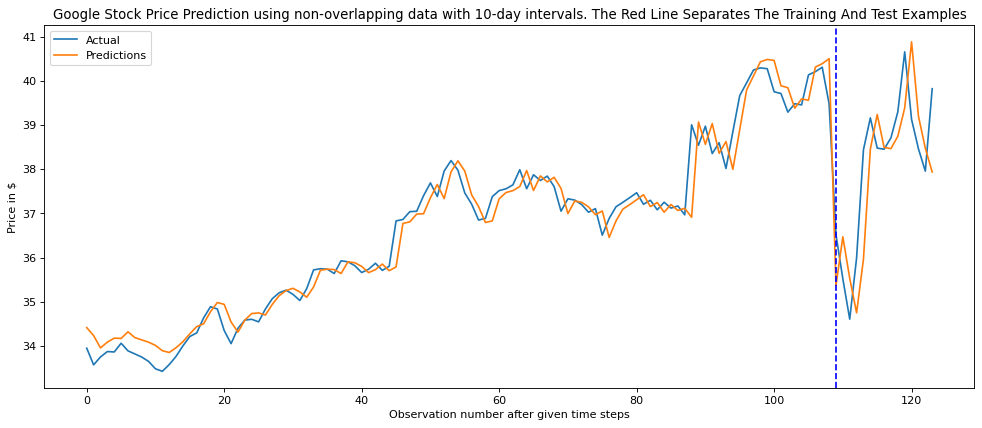

In [36]:
### See also https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvline.html
def plot_result(trainY1, testY1, train_predict1, test_predict1):
    actual = np.append(trainY1, testY1)
    predictions = np.append(train_predict1, test_predict1)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY1), color='b', linestyle='--') ### note: vertical red line separates training part from test part
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Observation number after given time steps')
    plt.ylabel('Price in $')
    plt.title('Google Stock Price Prediction using non-overlapping data with 10-day intervals. The Red Line Separates The Training And Test Examples')
    ### Plot result -- this puts together Actual = (trainY,testY) or 187+46 points, 
    ### and Predicted = (train_predict, test_predict)
plot_result(trainY1, testY1, train_predict1, test_predict1)

In [37]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA

In [38]:
mod = sm.tsa.arima.ARIMA(train_data,order=(1, 0, 1))
>>> model_fit = mod.fit()
>>> print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1100
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2969.126
Date:                Mon, 07 Nov 2022   AIC                          -5930.252
Time:                        16:09:04   BIC                          -5910.239
Sample:                             0   HQIC                         -5922.681
                               - 1100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4474      0.202      2.216      0.027       0.052       0.843
ar.L1          0.9984      0.002    549.030      0.000       0.995       1.002
ma.L1          0.0318      0.022      1.460      0.1

C:\Users\Administrator\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:
forecast_test=model_fit.forecast(len(test_data))
rmse = mean_squared_error(forecast_test, test_data)
rmse

0.09867788775805052